# Building the Predictive Model of Pollution Air Quality Indices
# Molly McNamara

## Import basic packages and dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from ggplot import *
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.api as sm


from IPython.display import display,HTML
pd.set_option("display.max.columns",500)
pd.set_option("display.max.rows",500)
%matplotlib inline
pollution = pd.read_csv('~/Desktop/weatherpollution.csv', index_col='Unnamed: 0')
pollution['Date_Local']= pd.to_datetime(pollution['Date_Local'],  errors='raise', format='%Y/%m/%d')
# Select for the cities with corresponding pollution and weather data
the7cities = ['New York', 'Los Angeles', 'Houston', 'Phoenix', 'Philadelphia', 'San Diego', 'Dallas']
pollution7 = pollution[pollution['City'].isin(the7cities)]
pollution7.describe()

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/mollymcnamara/anaconda/lib

,Site_Num,NO2_Mean,NO2_1stMaxValue,NO2_1stMaxHour,NO2_AQI,O3_Mean,O3_1stMaxValue,O3_1stMaxHour,O3_AQI,SO2_Mean,SO2_1stMaxValue,SO2_1stMaxHour,SO2_AQI,CO_Mean,CO_1stMaxValue,CO_1stMaxHour,CO_AQI,TempAvg,TempMax,TempMin,Elevation,Latitude,Longitude,AvgRelHumid,AvgDewPointTemp,AvgWetBulbTemp,Sunrise,Sunset,AvgStationPressure,AvgSeaLevelPressure,SustainedWindSpeed,SustainedWindDirection
count,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,56073.000000,55576.00000,55576.000000,55576.000000,48244.000000,48244.000000,48244.000000,43531.000000,43533.000000,43533.000000,48244.000000,48244.000000,48244.000000,43533.000000,48098.000000,48098.000000
mean,1705.768445,19.922606,36.264774,11.982469,34.208639,0.022574,0.036400,10.131311,32.910420,2.662308,5.484707,9.945638,8.588099,0.494266,0.862853,8.701354,8.332008,72.51049,73.152458,56.454027,76.495902,34.900695,-99.066550,64.116032,40.550020,49.291572,581.320185,1801.010426,29.652541,30.026183,18.205996,215.329951
std,2519.681700,10.817550,16.494427,7.769104,15.843286,0.011053,0.015641,3.991167,18.404656,3.407479,7.382645,6.685631,11.776887,0.379911,0.727501,6.736504,6.908859,14.16188,16.696224,14.699040,118.393967,3.774871,17.806223,19.700994,14.711799,11.803444,88.062569,90.918767,0.461684,0.170512,5.831168,90.989462
min,4.000000,-0.152174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.725155,-1.300000,0.000000,0.000000,-0.400000,-0.400000,0.000000,0.000000,0.00000,13.000000,2.000000,3.000000,29.980000,-118.388800,5.000000,-11.000000,6.000000,423.000000,1628.000000,28.240000,29.170000,5.000000,10.000000
25%,124.000000,11.826087,24.300000,6.000000,23.000000,0.014083,0.025000,9.000000,22.000000,0.531677,1.300000,5.000000,1.000000,0.239584,0.389500,3.500000,3.000000,66.00000,63.000000,47.000000,3.400000,32.733600,-117.183100,51.000000,30.000000,42.000000,521.000000,1728.000000,29.510000,29.930000,14.000000,150.000000
50%,1010.000000,18.375000,36.000000,10.000000,34.000000,0.021958,0.036000,10.000000,31.000000,1.652083,3.000000,8.000000,4.000000,0.393750,0.650000,7.500000,7.000000,73.00000,73.000000,57.000000,29.000000,33.427700,-96.855500,67.000000,37.000000,46.000000,559.000000,1815.000000,29.790000,30.060000,17.000000,250.000000
75%,2007.000000,26.487500,46.000000,20.000000,43.000000,0.030250,0.046000,11.000000,40.000000,3.467702,6.650000,14.000000,10.000000,0.637500,1.100000,11.500000,10.000000,84.00000,84.000000,67.000000,29.600000,39.873270,-75.226780,83.000000,51.000000,58.000000,646.000000,1859.000000,29.960000,30.100000,21.000000,280.000000
max,9997.000000,98.130435,163.000000,23.000000,113.000000,0.079458,0.130000,23.000000,206.000000,53.481250,174.500000,23.000000,176.000000,4.111795,7.850000,23.000000,66.000000,106.00000,119.000000,96.000000,337.400000,40.779200,-73.880000,99.000000,78.000000,80.000000,733.000000,1942.000000,30.730000,30.860000,62.000000,360.000000


## Prepare the data

AQI values were converted into categorical variables to use in the predictive model.  The categories generated were based on EPA advisory categories for Air Quality Index values.

### Create AQI categories

In [2]:
def AQI(x):
    if 0 <= x <= 50:
        return 'Good'
    elif 50 < x <= 100:
        return 'Moderate'
    elif 100 < x <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 150 < x <= 200:
        return 'Unhealthy'
    elif 200 < x <= 300:
        return 'Very Unhealthy'
    elif 300 < x <= 500:
        return 'Hazardous'
    
# Apply the function to create the new categories
pollution7['OzoneAQI'] = pollution7['O3_AQI'].apply(AQI)
pollution7['NitrogenDioxideAQI'] = pollution7['NO2_AQI'].apply(AQI)
pollution7['CarbonMonoxideAQI'] = pollution7['CO_AQI'].apply(AQI)
pollution7['SulfurDioxideAQI'] = pollution7['SO2_AQI'].apply(AQI)

# Convert them to category type and code numerically
ordered_AQI = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
pollution7['OzoneAQI'] = pollution7['OzoneAQI'].astype('category', ordered=True,
  categories=ordered_AQI).cat.codes
pollution7['NitrogenDioxideAQI'] = pollution7['NitrogenDioxideAQI'].astype('category', ordered=True,
  categories=ordered_AQI).cat.codes
pollution7['CarbonMonoxideAQI'] = pollution7['CarbonMonoxideAQI'].astype('category', ordered=True,
  categories=ordered_AQI).cat.codes
pollution7['SulfurDioxideAQI'] = pollution7['SulfurDioxideAQI'].astype('category', ordered=True,
  categories=ordered_AQI).cat.codes

# Ensure the numerical codes are category type
pollution7['OzoneAQI'] = pollution7['OzoneAQI'].astype('category')
pollution7['NitrogenDioxideAQI'] = pollution7['NitrogenDioxideAQI'].astype('category')
pollution7['CarbonMonoxideAQI'] = pollution7['CarbonMonoxideAQI'].astype('category')
pollution7['SulfurDioxideAQI'] = pollution7['SulfurDioxideAQI'].astype('category')
pollution7.dtypes

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Site_Num                           int64
Date_Local                datetime64[ns]
State                             object
County                            object
City                              object
NO2_Mean                         float64
NO2_1stMaxValue                  float64
NO2_1stMaxHour                   float64
NO2_AQI                          float64
O3_Mean                          float64
O3_1stMaxValue                   float64
O3_1stMaxHour                    float64
O3_AQI                           float64
SO2_Mean                         float64
SO2_1stMaxValue                  float64
SO2_1stMaxHour                   float64
SO2_AQI                          float64
CO_Mean                          float64
CO_1stMaxValue                   float64
CO_1stMaxHour                    float64
CO_AQI                           float64
TempAvg                          float64
TempMax                          float64
TempMin                          float64
Elevation       

### Define the features of interest
### Create train and test sets for each pollutant

In [3]:
# Specify features of interest
X = pollution7[['TempAvg', 'TempMax', 'TempMin', 'Elevation', 'AvgRelHumid', 'AvgDewPointTemp', 'Sunrise', 'Sunset', 'AvgStationPressure', 'AvgSeaLevelPressure', 'SustainedWindSpeed']]
feat_labels = ['TempAvg', 'TempMax', 'TempMin', 'Elevation', 'AvgRelHumid', 'AvgDewPointTemp', 'Sunrise', 'Sunset', 'AvgStationPressure', 'AvgSeaLevelPressure', 'SustainedWindSpeed']
y_oz = pollution7['OzoneAQI']
y_no = pollution7['NitrogenDioxideAQI']
y_co = pollution7['CarbonMonoxideAQI']
y_so = pollution7['SulfurDioxideAQI']

# Preprocess with Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_imp = imp.fit_transform(X)

# Create train and test sets
X_train_oz, X_test_oz, y_train_oz, y_test_oz = train_test_split(X_imp, y_oz, test_size=0.2, random_state=42)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_imp, y_no, test_size=0.2, random_state=42)
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(X_imp, y_co, test_size=0.2, random_state=42)
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(X_imp, y_so, test_size=0.2, random_state=42)

## Modeling

In order to predict the outcome variable, logistic regression will be used to develop the model. 

### Logistic Regression

In [4]:
# Setup the regression object
lr = LogisticRegression()

#### Ozone

In [5]:
# Fit the regression to the train set
lr.fit(X_train_oz, y_train_oz)
# Predict the labels of the test set
y_pred_oz = lr.predict(X_test_oz)
# Compute metrics
print('Ozone Model Accuracy', metrics.accuracy_score(y_test_oz, y_pred_oz))
print(metrics.classification_report(y_test_oz, y_pred_oz))

Ozone Model Accuracy 0.913776192599
             precision    recall  f1-score   support

          0       0.92      0.99      0.96     10248
          1       0.47      0.14      0.21       821
          2       0.00      0.00      0.00       135
          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00         1

avg / total       0.88      0.91      0.89     11215



/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
confusion_matrix(y_test_oz, y_pred_oz)

array([[10136,   112,     0,     0,     0],
       [  709,   112,     0,     0,     0],
       [  120,    15,     0,     0,     0],
       [   10,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0]])

#### Nitrogen Dioxide

In [7]:
# Fit the regression to the train set
lr.fit(X_train_no, y_train_no)
# Predict the labels of the test set
y_pred_no = lr.predict(X_test_no)
# Compute metrics
print('Nitrogen Dioxide Model Accuracy', metrics.accuracy_score(y_test_no, y_pred_no))
print(metrics.classification_report(y_test_no, y_pred_no))

Nitrogen Dioxide Model Accuracy 0.880606330807
             precision    recall  f1-score   support

          0       0.89      0.99      0.94      9798
          1       0.60      0.16      0.26      1369
          2       0.00      0.00      0.00        48

avg / total       0.85      0.88      0.85     11215



/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
confusion_matrix(y_test_no, y_pred_no)

array([[9652,  146,    0],
       [1145,  224,    0],
       [  45,    3,    0]])

#### Carbon Monoxide

In [9]:
# Fit the regression to the train set
lr.fit(X_train_co, y_train_co)
# Predict the labels of the test set
y_pred_co = lr.predict(X_test_co)
# Compute metrics
print('Carbon Monoxide Model Accuracy', metrics.accuracy_score(y_test_co, y_pred_co))
print(metrics.classification_report(y_test_co, y_pred_co))

Carbon Monoxide Model Accuracy 0.998395006687
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11197
          1       0.00      0.00      0.00        18

avg / total       1.00      1.00      1.00     11215



/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
confusion_matrix(y_test_co, y_pred_co)

array([[11197,     0],
       [   18,     0]])

#### Sulfur Dioxide

In [11]:
# Fit the regression to the train set
lr.fit(X_train_so, y_train_so)
# Predict the labels of the test set
y_pred_so = lr.predict(X_test_so)
# Compute metrics
print('Sulfur Dioxide Model Accuracy', metrics.accuracy_score(y_test_so, y_pred_so))
print(metrics.classification_report(y_test_so, y_pred_so))

Sulfur Dioxide Model Accuracy 0.984663397236
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     11043
          1       0.00      0.00      0.00       159
          2       0.00      0.00      0.00        13

avg / total       0.97      0.98      0.98     11215



/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
confusion_matrix(y_test_so, y_pred_so)

array([[11043,     0,     0],
       [  159,     0,     0],
       [   13,     0,     0]])

These models might appear to have high accuracies but when the confusion matrices are evaluated, they are actually fairly poor at discriminating the less populated classes.  Cross validation with balanced class weighting may help address this.

### Logistic Regression with Cross Validation

In [13]:
# Setup the regression object
lrcv = LogisticRegressionCV(class_weight='balanced', multi_class = 'multinomial')

#### Ozone

In [14]:
# Fit the regression to the train set
lrcv.fit(X_train_oz, y_train_oz)
# Predict the labels of the test set
y_pred_oz = lrcv.predict(X_test_oz)
# Compute metrics
print('Ozone Model Accuracy', metrics.accuracy_score(y_test_oz, y_pred_oz))
print(metrics.classification_report(y_test_oz, y_pred_oz))

Ozone Model Accuracy 0.726348640214
             precision    recall  f1-score   support

          0       0.98      0.76      0.85     10248
          1       0.22      0.42      0.29       821
          2       0.09      0.34      0.14       135
          3       0.01      0.70      0.02        10
          4       0.00      1.00      0.00         1

avg / total       0.91      0.73      0.80     11215



In [15]:
confusion_matrix(y_test_oz, y_pred_oz)

array([[7750, 1151,  327,  622,  398],
       [ 146,  342,  139,  138,   56],
       [   4,   33,   46,   21,   31],
       [   0,    1,    1,    7,    1],
       [   0,    0,    0,    0,    1]])

#### Nitrogen Dioxide

In [16]:
# Fit the regression to the train set
lrcv.fit(X_train_no, y_train_no)
# Predict the labels of the test set
y_pred_no = lrcv.predict(X_test_no)
# Compute metrics
print('Nitrogen Dioxide Model Accuracy', metrics.accuracy_score(y_test_no, y_pred_no))
print(metrics.classification_report(y_test_no, y_pred_no))

Nitrogen Dioxide Model Accuracy 0.640927329469
             precision    recall  f1-score   support

          0       0.95      0.66      0.78      9798
          1       0.25      0.49      0.33      1369
          2       0.02      0.77      0.04        48

avg / total       0.86      0.64      0.72     11215



In [17]:
confusion_matrix(y_test_no, y_pred_no)

array([[6476, 1993, 1329],
       [ 326,  675,  368],
       [   4,    7,   37]])

#### Carbon Monoxide

In [18]:
# Fit the regression to the train set
lrcv.fit(X_train_co, y_train_co)
# Predict the labels of the test set
y_pred_co = lrcv.predict(X_test_co)
# Compute metrics
print('Carbon Monoxide Model Accuracy', metrics.accuracy_score(y_test_co, y_pred_co))
print(metrics.classification_report(y_test_co, y_pred_co))

Carbon Monoxide Model Accuracy 0.813285777976
             precision    recall  f1-score   support

          0       1.00      0.81      0.90     11197
          1       0.01      1.00      0.02        18

avg / total       1.00      0.81      0.90     11215



In [19]:
confusion_matrix(y_test_co, y_pred_co)

array([[9103, 2094],
       [   0,   18]])

#### Sulfur Dioxide

In [20]:
# Fit the regression to the train set
lrcv.fit(X_train_so, y_train_so)
# Predict the labels of the test set
y_pred_so = lrcv.predict(X_test_so)
# Compute metrics
print('Sulfur Dioxide Model Accuracy', metrics.accuracy_score(y_test_so, y_pred_so))
print(metrics.classification_report(y_test_so, y_pred_so))

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Sulfur Dioxide Model Accuracy 0.667944716897
             precision    recall  f1-score   support

          0       1.00      0.67      0.80     11043
          1       0.03      0.47      0.06       159
          2       0.01      0.46      0.01        13
          3       0.00      0.00      0.00         0

avg / total       0.98      0.67      0.79     11215



/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [21]:
confusion_matrix(y_test_so, y_pred_so)

array([[7410, 2133,  936,  564],
       [  34,   75,   35,   15],
       [   3,    1,    6,    3],
       [   0,    0,    0,    0]])

The accuracy of the cross validated models are lower but perhaps slightly better in terms of predicting the classes.  The imbalance between the classes is still an issue.

In [22]:
pollution7.OzoneAQI.value_counts()

0    51301
1     4059
2      645
3       57
4       11
Name: OzoneAQI, dtype: int64

In [23]:
pollution7.CarbonMonoxideAQI.value_counts()

0    56005
1       68
Name: CarbonMonoxideAQI, dtype: int64

In [24]:
pollution7.SulfurDioxideAQI.value_counts()

0    55189
1      823
2       59
3        2
Name: SulfurDioxideAQI, dtype: int64

In [25]:
pollution7.NitrogenDioxideAQI.value_counts()

0    48855
1     7010
2      208
Name: NitrogenDioxideAQI, dtype: int64

These breakdowns show just how imbalanced the classes are.  From here, we can begin to tweak the models to improve the prediction.

### Improving the Models

#### Normalization of data

In [26]:
# First we normalize the X inputs
normalized_X = preprocessing.normalize(X_imp)

To better power the smaller classes, the air quality categories are reconfigured as a binary outcome of "Good" (AQI 0-50) and "Elevated" (greater than 50).

#### New Air Quality Categories

In [27]:
def AirQuality(x):
    if 0 <= x <= 50:
        return 'Good'
    elif 50 < x <= 500:
        return 'Elevated' 

pollution7['O3Quality'] = pollution7['O3_AQI'].apply(AirQuality)
pollution7['NO2Quality'] = pollution7['NO2_AQI'].apply(AirQuality)
pollution7['COQuality'] = pollution7['CO_AQI'].apply(AirQuality)
pollution7['SO2Quality'] = pollution7['SO2_AQI'].apply(AirQuality)

ordered = ['Good', 'Elevated']
pollution7['O3Quality'] = pollution7['O3Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['NO2Quality'] = pollution7['NO2Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['COQuality'] = pollution7['COQuality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['SO2Quality'] = pollution7['SO2Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes

pollution7['O3Quality'] = pollution7['O3Quality'].astype('category')
pollution7['NO2Quality'] = pollution7['NO2Quality'].astype('category')
pollution7['COQuality'] = pollution7['COQuality'].astype('category')
pollution7['SO2Quality'] = pollution7['SO2Quality'].astype('category')
pollution7.dtypes

/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

Site_Num                           int64
Date_Local                datetime64[ns]
State                             object
County                            object
City                              object
NO2_Mean                         float64
NO2_1stMaxValue                  float64
NO2_1stMaxHour                   float64
NO2_AQI                          float64
O3_Mean                          float64
O3_1stMaxValue                   float64
O3_1stMaxHour                    float64
O3_AQI                           float64
SO2_Mean                         float64
SO2_1stMaxValue                  float64
SO2_1stMaxHour                   float64
SO2_AQI                          float64
CO_Mean                          float64
CO_1stMaxValue                   float64
CO_1stMaxHour                    float64
CO_AQI                           float64
TempAvg                          float64
TempMax                          float64
TempMin                          float64
Elevation       

In [28]:
pollution7.O3Quality.value_counts()

0    51301
1     4772
Name: O3Quality, dtype: int64

In [29]:
pollution7.NO2Quality.value_counts()

0    48855
1     7218
Name: NO2Quality, dtype: int64

In [30]:
pollution7.COQuality.value_counts()

0    56005
1       68
Name: COQuality, dtype: int64

In [31]:
pollution7.SO2Quality.value_counts()

0    55189
1      884
Name: SO2Quality, dtype: int64

Even with this combination of pollutant categories, the dataset is simply underpowered when it comes to elevated Carbon Monoxide and Sulfur Dioxide levels. In nearly 50,000 observations, there are not enough to sufficiently power a predictive model.  The analysis going forward will focus on pollutants with high levels observed, Ozone and Nitrogen Dioxide.

#### Define outcome variables and new train/test sets

In [32]:
# Specify new outcome variables:
y_ozq = pollution7['O3Quality']
y_noq = pollution7['NO2Quality']

In [33]:
# Set up new test and train sets
X_train_oz, X_test_oz, y_train_oz, y_test_oz = train_test_split(normalized_X, y_ozq, test_size=0.2, random_state=42)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(normalized_X, y_noq, test_size=0.2, random_state=42)

In [34]:
# Setup the regression object (no longer multinomial)
lrcvb = LogisticRegressionCV(class_weight='balanced')

#### Linear Regression - Ozone

In [35]:
# Fit the regression to the train set
lrcvb.fit(X_train_oz, y_train_oz)
# Predict the labels of the test set
y_pred_oz = lrcvb.predict(X_test_oz)
# Compute metrics
print('Ozone Model Accuracy', metrics.accuracy_score(y_test_oz, y_pred_oz))
print(metrics.classification_report(y_test_oz, y_pred_oz))

Ozone Model Accuracy 0.789656709764
             precision    recall  f1-score   support

          0       0.98      0.78      0.87     10248
          1       0.27      0.86      0.41       967

avg / total       0.92      0.79      0.83     11215



In [36]:
confusion_matrix(y_test_oz, y_pred_oz)

array([[8029, 2219],
       [ 140,  827]])

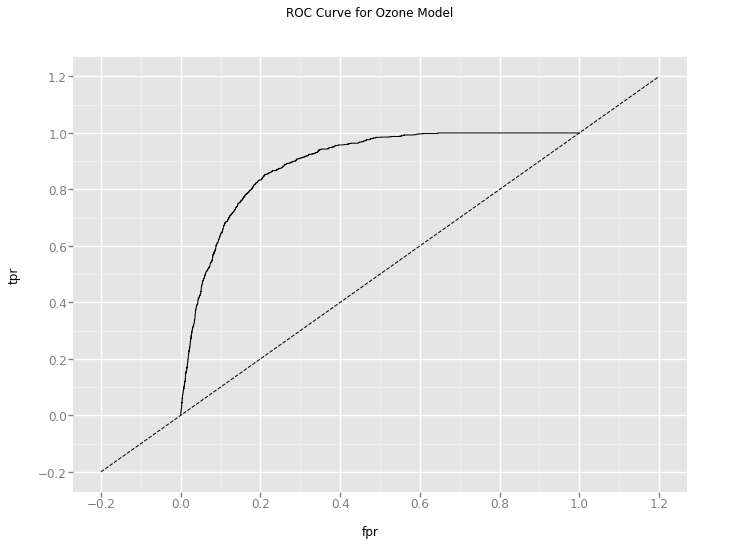

<ggplot: (-9223372036562730948)>

In [37]:
preds = lrcvb.predict_proba(X_test_oz)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test_oz, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("ROC Curve for Ozone Model")


In [38]:
print('AUC = ', metrics.auc(fpr,tpr))

AUC =  0.892030033656


#### Linear Regression - Nitrogen Dioxide

In [39]:
# Fit the regression to the train set
lrcvb.fit(X_train_no, y_train_no)
# Predict the labels of the test set
y_pred_no = lrcvb.predict(X_test_no)
# Compute metrics
print('Nitrogen Dioxide Model Accuracy', metrics.accuracy_score(y_test_no, y_pred_no))
print(metrics.classification_report(y_test_no, y_pred_no))

Nitrogen Dioxide Model Accuracy 0.718769505127
             precision    recall  f1-score   support

          0       0.95      0.72      0.82      9798
          1       0.27      0.74      0.40      1417

avg / total       0.87      0.72      0.76     11215



In [40]:
confusion_matrix(y_test_no, y_pred_no)

array([[7006, 2792],
       [ 362, 1055]])

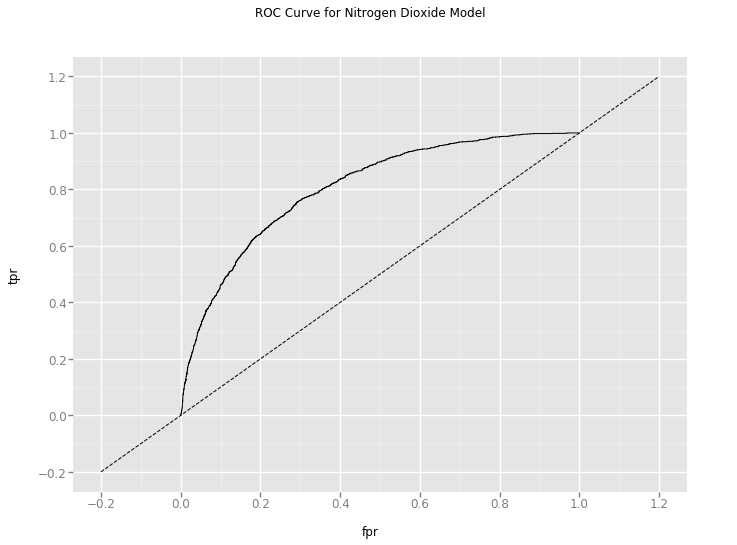

<ggplot: (289415351)>

In [41]:
preds = lrcvb.predict_proba(X_test_no)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test_no, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("ROC Curve for Nitrogen Dioxide Model")

In [42]:
print('AUC = ', metrics.auc(fpr,tpr))

AUC =  0.806232797355


Normalizing the features of interest and recategorizing the outcome variables have improved the predictive power of these models.  The next step is to determine what the most influential features are. 

## Feature Importance

Recursive feature elimination can be used to evaluate the features of greatest importance to the model.  Additionally, logistic regression can be performed using the statsmodels package to list the regression coefficients as a secondary check of the most influential features.

In [44]:
#Define the recursive feature elimination object
rfe = RFE(lrcvb)

### Ozone

#### Recursive Feature Elimination

In [45]:
rfe.fit(normalized_X, y_ozq)
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), feat_labels)))

Features sorted by their rank:
[(1, 'AvgSeaLevelPressure'), (1, 'AvgStationPressure'), (1, 'SustainedWindSpeed'), (1, 'TempAvg'), (1, 'TempMax'), (2, 'TempMin'), (3, 'Sunset'), (4, 'Sunrise'), (5, 'Elevation'), (6, 'AvgDewPointTemp'), (7, 'AvgRelHumid')]


#### Logistic Regression via StatsModels

In [46]:
logitoz = sm.Logit(y_ozq, normalized_X)

# fit the model
resultoz = logitoz.fit()

resultoz.summary()

         Current function value: 10.393081
         Iterations: 35


/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              O3Quality   No. Observations:                56073
Model:                          Logit   Df Residuals:                    56062
Method:                           MLE   Df Model:                           10
Date:                Tue, 26 Dec 2017   Pseudo R-squ.:                  -34.71
Time:                        17:39:34   Log-Likelihood:            -5.8277e+05
converged:                      False   LL-Null:                       -16321.
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.125e+04    754.076    -14.917      0.000   -1.27e+04   -9770.910
x2          1.783e+04   1196.334     14.906      0.000    1.55e+04    2.02e+04
x3          2964.6386    208.101     14.246      0.000    2556.768    3372.509
x4          4868.2351    326.536     14.909      0.000    4228.237    5508.234
x5          7908.8418    530.463     14.909      0.000    6869.154    8948.530
x6         -7409.7358    498.136    -14.875      0.000   -8386.064   -6433.408
x7         -1443.9100     97.512    -14.808      0.000   -1635.030   -1252.790
x8           -77.5630      8.227     -9.428      0.000     -93.687     -61.439
x9          1.254e+06   8.42e+04     14.905      0.000    1.09e+06    1.42e+06
x10        -1.255e+06   8.42e+04    -14.905      0.000   -1.42e+06   -1.09e+06
x11        -6954.1787    469.726    -14.805      0.000   -7874.825   -6033.532
==============================================================================

Possibly complete quasi-separation: A fraction 0.87 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [43]:
#As a reminder of the features of interest
feat_labels

['TempAvg',
 'TempMax',
 'TempMin',
 'Elevation',
 'AvgRelHumid',
 'AvgDewPointTemp',
 'Sunrise',
 'Sunset',
 'AvgStationPressure',
 'AvgSeaLevelPressure',
 'SustainedWindSpeed']

The statsmodel regression for ozone therefore shows the largest coefficients for TempAvg, TempMax, AvgStationPressure, and AvgSeaLevelPressure, followed by AvgRelHumid, AvgDewPointTemp and SustainedWindSpeed.

### Nitrogen Dioxide

#### Recursive Feature Elimination

In [47]:
rfe.fit(normalized_X, y_noq)
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), feat_labels)))

Features sorted by their rank:
[(1, 'AvgSeaLevelPressure'), (1, 'AvgStationPressure'), (1, 'SustainedWindSpeed'), (1, 'TempMax'), (1, 'TempMin'), (2, 'AvgDewPointTemp'), (3, 'AvgRelHumid'), (4, 'TempAvg'), (5, 'Sunset'), (6, 'Sunrise'), (7, 'Elevation')]


#### Logistic Regression via StatsModels

In [48]:
logitno = sm.Logit(y_noq, normalized_X)

# fit the model
resultno = logitno.fit()

resultno.summary()

         Current function value: 0.309462
         Iterations: 35


/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             NO2Quality   No. Observations:                56073
Model:                          Logit   Df Residuals:                    56062
Method:                           MLE   Df Model:                           10
Date:                Tue, 26 Dec 2017   Pseudo R-squ.:                  0.1940
Time:                        17:39:59   Log-Likelihood:                -17352.
converged:                      False   LL-Null:                       -21530.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -45.6901      2.700    -16.923      0.000     -50.982     -40.398
x2           289.2320      4.606     62.796      0.000     280.205     298.259
x3          -281.4633      5.080    -55.401      0.000    -291.421    -271.506
x4            -2.3399      0.822     -2.848      0.004      -3.950      -0.730
x5            50.2030      1.983     25.313      0.000      46.316      54.090
x6           -52.6150      3.054    -17.228      0.000     -58.601     -46.629
x7           -18.5907      0.746    -24.934      0.000     -20.052     -17.129
x8           -16.4242      0.625    -26.275      0.000     -17.649     -15.199
x9         -1633.8285    189.192     -8.636      0.000   -2004.638   -1263.019
x10         2831.7736    187.306     15.118      0.000    2464.660    3198.887
x11         -205.0454      6.535    -31.377      0.000    -217.853    -192.237
==============================================================================
"""

In [43]:
#As a reminder of the features of interest
feat_labels

['TempAvg',
 'TempMax',
 'TempMin',
 'Elevation',
 'AvgRelHumid',
 'AvgDewPointTemp',
 'Sunrise',
 'Sunset',
 'AvgStationPressure',
 'AvgSeaLevelPressure',
 'SustainedWindSpeed']

The statsmodel regression for nitrogen dioxide therefore shows the largest coefficients for AvgSeaLevelPressure, AvgStationPressure, TempMax and TempMin, followed by SustainedWindSpeed.

## Random Forest Classification

For a different comparison, random forest classification was also tested to see if the same features would prove critical in a different type of model.

In [54]:
clf_rf = RandomForestClassifier(n_estimators=10, random_state=12)

#### Ozone

In [55]:
clf_rf.fit(normalized_X, y_ozq)
clf_rf.score(X_test_oz, y_test_oz)

0.97922425323227824

In [56]:
for feature in zip(feat_labels, clf_rf.feature_importances_):
    print(feature)

('TempAvg', 0.078504308923818697)
('TempMax', 0.20123682733248352)
('TempMin', 0.094882909782988259)
('Elevation', 0.076469945674598458)
('AvgRelHumid', 0.080082424363007415)
('AvgDewPointTemp', 0.071477128822854605)
('Sunrise', 0.080677009463820587)
('Sunset', 0.076749722598495995)
('AvgStationPressure', 0.093536304922682778)
('AvgSeaLevelPressure', 0.064470449951606293)
('SustainedWindSpeed', 0.081912968163643393)


#### Nitrogen Dioxide

In [57]:
clf_rf.fit(normalized_X, y_noq)
clf_rf.score(X_test_no, y_test_no)

0.95639768167632633

In [53]:
for feature in zip(feat_labels, clf_rf.feature_importances_):
    print(feature)

('TempAvg', 0.094883865676839638)
('TempMax', 0.1399248233442095)
('TempMin', 0.10175030657574141)
('Elevation', 0.078229794151972468)
('AvgRelHumid', 0.10479879108150718)
('AvgDewPointTemp', 0.090427346648805168)
('Sunrise', 0.072029732830115101)
('Sunset', 0.075613905767378697)
('AvgStationPressure', 0.071724383201727082)
('AvgSeaLevelPressure', 0.066357621602269601)
('SustainedWindSpeed', 0.10425942911943414)


These results corroborate the feature importance results determined via logistic regression.